In [254]:
# IMPORT LIBRAIRIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [255]:
# IMPORT DATA

btc = yf.download(tickers = 'BTC-USD')[['Close']]
btc.index = pd.DatetimeIndex(btc.index.values, freq = btc.index.inferred_freq)

[*********************100%***********************]  1 of 1 completed


In [256]:
# CHECK DATA

btc.head()

,Close
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


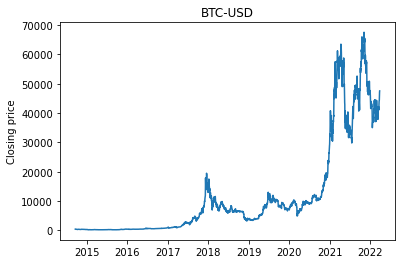

In [257]:
# PLOT DATA

fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close', data = btc, ax = ax)
ax.set_title('BTC-USD')
ax.set_ylabel('Closing price')
plt.show()

In [258]:
# Let's consider only data since Jan 2021 only
idx_todrop = pd.date_range(start = btc.iloc[0].name.date(), end = '2020-12-31')
btc.drop(idx_todrop, inplace=True)

/var/folders/lc/q1lfsr356d11n9j92x9l_x080000gn/T/ipykernel_80924/562977744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc.drop(idx_todrop, inplace=True)


In [259]:
btc.head()

,Close
2021-01-01,29374.152344
2021-01-02,32127.267578
2021-01-03,32782.023438
2021-01-04,31971.914062
2021-01-05,33992.429688


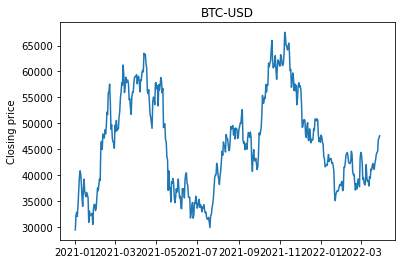

In [260]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close', data = btc, ax = ax)
ax.set_title('BTC-USD')
ax.set_ylabel('Closing price')
plt.show()

In [261]:
# CHECK STATIONARITY
# From the graph above, we can definitely conclude that there is no stationarity.
# Let's confirm this with ADFULLER and KPSS tests.

# ADFULLER
from statsmodels.tsa.stattools import adfuller

result = adfuller(btc.Close)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

ADF Test Statistic: -2.51
5% Critical Value: -2.87
p-value: 0.11


In [262]:
# p-value of 0.11: the time series is not stationary.

In [263]:
# KPSS
from statsmodels.tsa.stattools import kpss

result = kpss(btc.Close)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

(0.20386028378079604, 0.1, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.20
5% Critical Value: 0.46
p-value: 0.10


/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [264]:
# p-value above 0.10: the time series is stationary.

# KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary.
# Trend needs to be removed to make series strict stationary. 
# Let's create a function to make the time series stationary.

def make_stationary(time_series, diff_depth = 10):
    for i in range(1, diff_depth+1):
        time_series_stationary = time_series.diff(periods = i).dropna()
        if (adfuller(time_series_stationary)[1] < 0.05) and (kpss(time_series_stationary)[1] > 0.05):
            print(f'Stationary time series found with differenciating depth of {i}.')
            return time_series_stationary
    return None

btc['Close_stationary'] = make_stationary(btc.Close)

if not btc.Close_stationary.any():
    print('Please increase depth of differenciation.')

Stationary time series found with differenciating depth of 1.


/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/var/folders/lc/q1lfsr356d11n9j92x9l_x080000gn/T/ipykernel_80924/1061917828.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Close_stationary'] = make_stationary(btc.Close)


In [265]:
btc.head()

,Close,Close_stationary
2021-01-01,29374.152344,NaN
2021-01-02,32127.267578,2753.115234
2021-01-03,32782.023438,654.755859
2021-01-04,31971.914062,-810.109375
2021-01-05,33992.429688,2020.515625


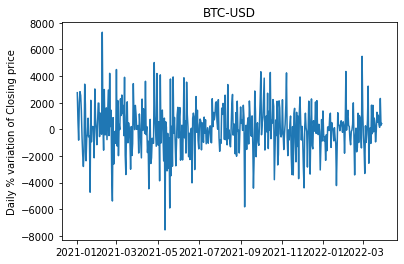

In [266]:
# PLOT DATA

fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close_stationary', data = btc, ax = ax)
ax.set_title('BTC-USD')
ax.set_ylabel('Daily variation of Closing price')
plt.show()

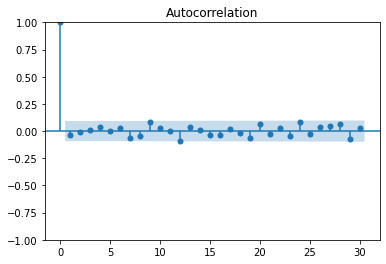

In [267]:
# CHECK AUTO-CORRELATION
from statsmodels.graphics.tsaplots import plot_acf
# Calculate the ACF (via statsmodel)
plot_acf(btc.Close_stationary.dropna(), alpha =0.05, lags=30)
# Show the data as a plot (via matplotlib)
plt.show()

In [268]:
# No auto-correlation of the stationary time series

/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


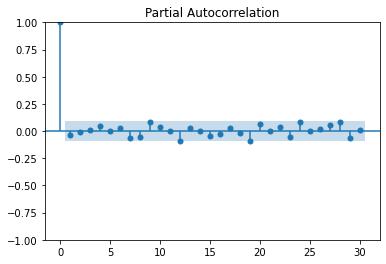

In [269]:
# PARTIAL AUTO-CORRELATION
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(btc.Close_stationary.dropna(), alpha =0.05, lags= 30)
plt.show()

In [270]:
# No partial auto-correlation of the stationary time series

In [279]:
# The time series is now stationary and not auto-correlated, we can implement AR and MA models

from statsmodels.tsa.arima.model import ARIMA
from sklearn import metrics


def implement_arima_model(data, order):
    model = ARIMA(data, order = order, freq = 'D')
    results = model.fit()
    p = order[0]
    d = order[1]
    q = order[2]
    y_true = data.values
    y_pred = results.predict(n_periods = len(data))
    if p>0:
        if q>0:
            if d>0:
                model_name = f'ARIMA({p},{d},{q})'
            else:
                model_name = f'ARMA({p},{q})'
        else:
            model_name = f'AR({p})'
    else:
        model_name = f'MA({q})'
    MAE = metrics.mean_absolute_error(y_true=y_true, y_pred = y_pred)
    MAPE = metrics.mean_absolute_percentage_error(y_true=y_true, y_pred = y_pred)
    MSE = metrics.mean_squared_error(y_true=y_true, y_pred = y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_true=y_true, y_pred = y_pred))
    NRMSE = np.sqrt(metrics.mean_squared_error(y_true=y_true, y_pred = y_pred)) / (np.max(y_true) - np.min(y_true))
    AIC = results.aic
    BIC = results.bic
    return [model_name, MAE, MAPE, MSE, RMSE, NRMSE, AIC, BIC]
    
cols = ['MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'AIC', 'BIC']

df_model_comparison = pd.DataFrame(columns = cols)

# AR(1) to AR(3)
for p in range(1,3+1):
    model_results = implement_arima_model(btc.Close_stationary.dropna(), order = (p,0,0))
    df_results = pd.DataFrame([model_results[1:]], index = [model_results[0]], columns = cols)
    df_model_comparison = pd.concat([df_model_comparison, df_results])

# MA(1) to MA(3)
for q in range(1,3+1):
    model_results = implement_arima_model(btc.Close_stationary.dropna(), order = (0,0,q))
    df_results = pd.DataFrame([model_results[1:]], index = [model_results[0]], columns = cols)
    df_model_comparison = pd.concat([df_model_comparison, df_results])

# ARMA(1,1) to ARMA(3,3)
for p in range(1, 3+1):
    for q in range(1,3+1):
        model_results = implement_arima_model(btc.Close_stationary.dropna(), order = (p,0,q))
        df_results = pd.DataFrame([model_results[1:]], index = [model_results[0]], columns = cols)
        df_model_comparison = pd.concat([df_model_comparison, df_results])

df_model_comparison


/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

,MAE,MAPE,MSE,RMSE,NRMSE,AIC,BIC
AR(1),1338.799359,1.023424,3321449.970573,1822.48456,0.122751,8075.913049,8088.254095
AR(2),1338.077003,1.02415,3321323.303011,1822.449808,0.122748,8077.894301,8094.34903
AR(3),1337.849065,1.025662,3321149.348339,1822.402082,0.122745,8079.870717,8100.439128
MA(1),1338.649513,1.017471,3321413.166547,1822.474463,0.12275,8075.906464,8088.24751
MA(2),1338.197344,1.021676,3321350.079529,1822.457154,0.122749,8077.898987,8094.353716
MA(3),1337.732598,1.026462,3321006.574487,1822.36291,0.122742,8079.879387,8100.447798
"ARMA(1,1)",1338.420658,1.017954,3321377.722604,1822.464738,0.122749,8077.901646,8094.356375
"ARMA(1,2)",1338.132701,1.022738,3321333.213463,1822.452527,0.122748,8079.896679,8100.46509
"ARMA(1,3)",1338.191682,1.037865,3320328.21262,1822.176779,0.12273,8081.790683,8106.472777
"ARMA(2,1)",1338.094856,1.023765,3321328.339667,1822.45119,0.122748,8079.894938,8100.463349


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  453
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4035.279
Date:                Tue, 29 Mar 2022   AIC                           8076.558
Time:                        13:04:10   BIC                           8088.899
Sample:                    01-01-2021   HQIC                          8081.421
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0763      6.118      0.012      0.990     -11.916      12.068
ma.L1         -0.0687      6.119     -0.011      0.991     -12.062      11.925
sigma2      3.324e+06    1.7e+05     19.593      0.000    2.99e+06    3.66e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                44.14
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# All very similar models...

In [283]:
# ARIMA: using auto_arima
import pmdarima as pm
model = pm.arima.auto_arima(btc.Close, trace = True, error_action='ignore', suppress_warnings=True, seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8103.802, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11036.738, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8102.722, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9938.293, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8101.454, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8102.435, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8095.918, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9060.816, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8094.275, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9559.388, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8095.895, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8097.

In [275]:
model.fit(btc.Close)

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [284]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  453
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4044.138
Date:                Tue, 29 Mar 2022   AIC                           8094.275
Time:                        13:06:08   BIC                           8106.623
Sample:                             0   HQIC                          8099.141
                                - 453                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1114.5679    369.453      3.017      0.003     390.453    1838.683
ar.L1          0.9755      0.008    118.666      0.000       0.959       0.992
sigma2      3.279e+06      0.064   5.15e+07      0.000    3.28e+06    3.28e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                36.98
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+23. Standard errors may be unstable.
"""

In [276]:
forecast = model.predict(n_periods = 5)
forecast = pd.DataFrame(forecast, columns = ['Prediction'])
forecast.set_index(pd.date_range(start = btc.iloc[-1].name.date() + pd.DateOffset(1), end = btc.iloc[-1].name.date() + pd.DateOffset(5)), inplace = True)
forecast

,Prediction
2022-03-30,47509.217083
2022-03-31,47459.800294
2022-04-01,47411.594226
2022-04-02,47364.569216
2022-04-03,47318.696327


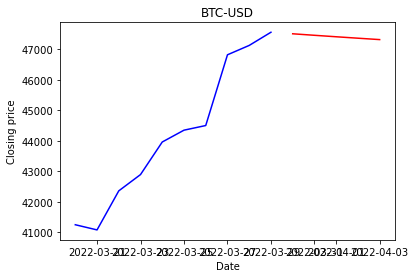

In [281]:
fig = plt.figure()
ax = fig.add_subplot(111)
btc_zoom = btc.tail(10)
sns.lineplot(x = btc_zoom.index, y='Close', data = btc_zoom, ax = ax, color = "blue")
sns.lineplot(x = forecast.index , y = 'Prediction', data = forecast, ax = ax, color = "red")
ax.set_title('BTC-USD')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price')
plt.show()

In [278]:
# According to the (not great) model, BTC price is likely to decrease, so I should not buy BTC now.